# *Enunciado*
1.      A partir de un dataset de residuos sólidos, utilizar o generar un modelo preentrenado (de acuerdo a elección, el mismo no deberá ser inferior al año 2019, debe lograr conseguir un error menor al 15% y una precisión superior al 90% en clasificación de al menos 5 clases de residuos sólidos. Entrenar el modelo utilizando transfer learning y fine tunning de acuerdo al modelo asignado, analizar y explicar los resultados obtenidos. (El modelo de red elegido debe ser comunicado a su compañero) (Obligatoria para todos).

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import zipfile

zip_path = '/content/drive/MyDrive/Datasets/GARBAGE-CLASSIFICATION.zip'

PATH = '/content/Garbage Classification'

if not os.path.exists(PATH):
    os.makedirs(PATH)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(PATH)

In [ ]:
# ------------------------------

PATH = '/content/Garbage Classification/GARBAGE CLASSIFICATION/garbage classification/Garbage classification' # <-------------

classes = os.listdir(PATH)
classes

['glass', 'cardboard', 'paper', 'plastic', 'metal', 'trash']

In [ ]:
nombres_nuevos = {
    'cardboard': 'Carton',
    'glass': 'Vidrio',
    'metal': 'Metal',
    'paper': 'Papel',
    'plastic': 'Plastico',
    'trash': 'Basura'
}

PATH = '/content/Garbage Classification/GARBAGE CLASSIFICATION/garbage classification/Garbage classification'

for carpeta in os.listdir(PATH):
    if carpeta in nombres_nuevos:
        carpeta_original = os.path.join(PATH, carpeta)
        carpeta_nueva = os.path.join(PATH, nombres_nuevos[carpeta])
        os.rename(carpeta_original, carpeta_nueva)

classes = os.listdir(PATH)
classes

['Basura', 'Metal', 'Papel', 'Carton', 'Plastico', 'Vidrio']

In [ ]:
import random
from skimage import io
import matplotlib.pyplot as plt

imgs, labels = [], []

for i, lab in enumerate(classes):
  paths = os.listdir(f'{PATH}/{lab}')
  print(f'Categoría: {lab}. Imágenes: {len(paths)}')

  for img_path in paths:
    full_path = f'{PATH}/{lab}/{img_path}'
    img = io.imread(full_path)

    # Verificar si la imagen tiene 3 canales (RGB)
    if img.ndim == 3 and img.shape[2] == 3:
      imgs.append(full_path)
      labels.append(i)


Categoría: Basura. Imágenes: 137
Categoría: Metal. Imágenes: 410
Categoría: Papel. Imágenes: 594
Categoría: Carton. Imágenes: 403
Categoría: Plastico. Imágenes: 482
Categoría: Vidrio. Imágenes: 501


In [ ]:
len(imgs)

2527

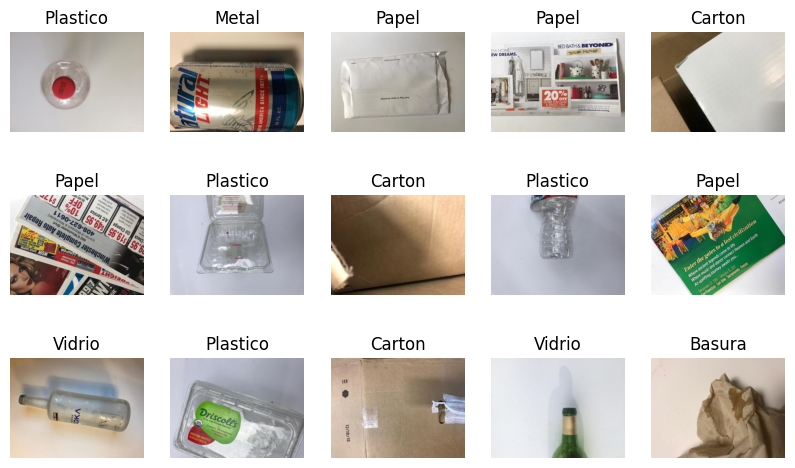

In [ ]:
import random
from skimage import io
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3,5, figsize=(10,6))
for _ax in axs:
  for ax in _ax:
    ix = random.randint(0, len(imgs)-1)
    img = io.imread(imgs[ix])     # Texto
    ax.imshow(img)                # imagen
    ax.axis('off')
    ax.set_title(classes[labels[ix]])
plt.show()

In [ ]:
# ------------------------------

from sklearn.model_selection import train_test_split

train_imgs, test_imgs, train_labels, test_labels = train_test_split(imgs, labels, test_size=0.2, stratify=labels)

len(train_imgs), len(test_imgs)

(2021, 506)

In [ ]:
# ------------------------------

import torch
device = "cuda" if torch.cuda.is_available() else "cpu"

class Dataset(torch.utils.data.Dataset):
  def __init__(self, X, y, trans, device):
    self.X = X
    self.y = y
    self.trans = trans
    self.device = device

  def __len__(self):
    return len(self.X)

  def __getitem__(self, ix):
    # cargar la imágen
    img = io.imread(self.X[ix])
    # aplicar transformaciones
    #print(f"imagen: {img}")
    if self.trans:
      img = self.trans(image=img)["image"]
                                # Normalmente es Ancho Alto y Nº de Canales pero lo cambiamos a que sea el Nº de canales primero
    return torch.from_numpy(img / 255.).float().permute(2,0,1), torch.tensor(self.y[ix])

In [ ]:
# ------------------------------

import albumentations as A

trans = A.Compose([
    A.Resize(384, 512)
])
# Aqui se crea el dataset
dataset = {
    'train': Dataset(train_imgs, train_labels, trans, device),
    'test': Dataset(test_imgs, test_labels, trans, device)
}

len(dataset['train']), len(dataset['test'])

(2021, 506)

In [ ]:
# ------------------------------

dataset['train'][2]

(tensor([[[0.8980, 0.8980, 0.8980,  ..., 0.5490, 0.5529, 0.5529],
          [0.8980, 0.8980, 0.8980,  ..., 0.5451, 0.5451, 0.5451],
          [0.8980, 0.8980, 0.8980,  ..., 0.5373, 0.5412, 0.5412],
          ...,
          [0.8157, 0.8157, 0.8157,  ..., 0.9176, 0.9176, 0.9176],
          [0.8157, 0.8157, 0.8157,  ..., 0.9176, 0.9176, 0.9176],
          [0.8157, 0.8157, 0.8157,  ..., 0.9176, 0.9176, 0.9176]],
 
         [[0.8980, 0.8980, 0.8980,  ..., 0.4157, 0.4196, 0.4196],
          [0.8980, 0.8980, 0.8980,  ..., 0.4118, 0.4118, 0.4118],
          [0.8980, 0.8980, 0.8980,  ..., 0.4039, 0.4078, 0.4078],
          ...,
          [0.8118, 0.8118, 0.8118,  ..., 0.9176, 0.9176, 0.9176],
          [0.8118, 0.8118, 0.8118,  ..., 0.9176, 0.9176, 0.9176],
          [0.8118, 0.8118, 0.8118,  ..., 0.9176, 0.9176, 0.9176]],
 
         [[0.9451, 0.9451, 0.9451,  ..., 0.3059, 0.3098, 0.3098],
          [0.9451, 0.9451, 0.9451,  ..., 0.3020, 0.3020, 0.3020],
          [0.9451, 0.9451, 0.9451,  ...,

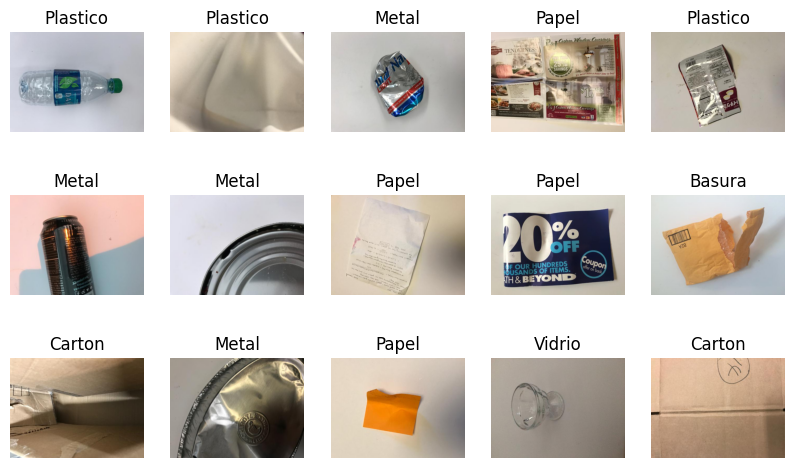

In [ ]:
# ------------------------------

fig, axs = plt.subplots(3,5, figsize=(10,6))
for _ax in axs:
  for ax in _ax:
    ix = random.randint(0, len(dataset['train'])-1)
    img, lab = dataset['train'][ix]
    ax.imshow(img.permute(1,2,0))
    ax.axis('off')
    ax.set_title(classes[lab])
plt.show()

In [ ]:
# ------------------------------

dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=32, shuffle=True, pin_memory=True),
    'test': torch.utils.data.DataLoader(dataset['test'], batch_size=128, shuffle=False)
}

imgs, labels = next(iter(dataloader['train']))
imgs.shape

torch.Size([32, 3, 384, 512])

# **Usando el modelo**

In [ ]:
import torchvision.models as models

models.mobilenet_v3_large()

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

In [ ]:
# ------------------------------
#

from tqdm import tqdm
import numpy as np

def fit(model, dataloader, epochs=5, lr=1e-2):
    model.to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()
    for epoch in range(1, epochs+1):
        model.train()
        train_loss, train_acc = [], []
        bar = tqdm(dataloader['train'])
        for batch in bar:
            X, y = batch
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
            train_acc.append(acc)
            bar.set_description(f"loss {np.mean(train_loss):.5f} acc {np.mean(train_acc):.5f}")
        bar = tqdm(dataloader['test'])
        val_loss, val_acc = [], []
        model.eval()
        with torch.no_grad():
            for batch in bar:
                X, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                loss = criterion(y_hat, y)
                val_loss.append(loss.item())
                acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
                val_acc.append(acc)
                bar.set_description(f"val_loss {np.mean(val_loss):.5f} val_acc {np.mean(val_acc):.5f}")
        print(f"Epoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} val_loss {np.mean(val_loss):.5f} acc {np.mean(train_acc):.5f} val_acc {np.mean(val_acc):.5f}")

# Modelo

--------------------

In [ ]:
import torchvision.models as models
import torch.nn as nn

class ModelCustom(torch.nn.Module):
    def __init__(self, n_outputs=5, pretrained=False, freeze=False):
        super().__init__()

        mobilenetv3 = models.mobilenet_v3_large(pretrained=pretrained)

        self.mobilenetv3 = nn.Sequential(*list(mobilenetv3.children())[:-1])

        if freeze:
            for param in self.mobilenetv3.parameters():
                param.requires_grad = False

        self.fc = nn.Linear(960, 6)

    def forward(self, x):
        x = self.mobilenetv3(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x

    def unfreeze(self):
        for param in self.mobilenetv3.parameters():
            param.requires_grad = True


# Transfer Learning

In [ ]:
model_c = ModelCustom(pretrained=True, freeze=True)
fit(model_c, dataloader, epochs=7)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth
100%|██████████| 9.83M/9.83M [00:00<00:00, 61.3MB/s]
val_loss 1.48232 val_acc 0.53935: 100%|██████████| 4/4 [00:03<00:00,  1.16it/s]


Epoch 1/7 loss 1.54169 val_loss 1.48232 acc 0.42842 val_acc 0.53935


val_loss 1.31696 val_acc 0.55293: 100%|██████████| 4/4 [00:03<00:00,  1.19it/s]


Epoch 2/7 loss 1.30238 val_loss 1.31696 acc 0.61875 val_acc 0.55293


val_loss 1.19803 val_acc 0.58651: 100%|██████████| 4/4 [00:04<00:00,  1.01s/it]


Epoch 3/7 loss 1.16411 val_loss 1.19803 acc 0.66680 val_acc 0.58651


val_loss 1.11712 val_acc 0.62401: 100%|██████████| 4/4 [00:03<00:00,  1.21it/s]


Epoch 4/7 loss 1.06983 val_loss 1.11712 acc 0.68027 val_acc 0.62401


val_loss 1.05248 val_acc 0.63806: 100%|██████████| 4/4 [00:03<00:00,  1.20it/s]


Epoch 5/7 loss 1.00516 val_loss 1.05248 acc 0.70615 val_acc 0.63806


val_loss 0.97472 val_acc 0.68337: 100%|██████████| 4/4 [00:04<00:00,  1.02s/it]


Epoch 6/7 loss 0.96164 val_loss 0.97472 acc 0.69521 val_acc 0.68337


val_loss 0.92222 val_acc 0.70252: 100%|██████████| 4/4 [00:03<00:00,  1.19it/s]

Epoch 7/7 loss 0.90327 val_loss 0.92222 acc 0.72686 val_acc 0.70252


Precisión del 92%

## Fine Tuning


In [ ]:
model_o = ModelCustom(pretrained=True, freeze=True)
fit(model_o, dataloader, epochs=15)
model_o.unfreeze()
print("-----------------------------------------------")
fit(model_o, dataloader, epochs=15, lr=1e-4)

val_loss 1.37645 val_acc 0.55546: 100%|██████████| 4/4 [00:04<00:00,  1.16s/it]


Epoch 1/15 loss 1.46434 val_loss 1.37645 acc 0.49844 val_acc 0.55546


val_loss 1.19153 val_acc 0.61668: 100%|██████████| 4/4 [00:04<00:00,  1.01s/it]


Epoch 2/15 loss 1.12947 val_loss 1.19153 acc 0.67578 val_acc 0.61668


val_loss 1.01514 val_acc 0.69371: 100%|██████████| 4/4 [00:04<00:00,  1.09s/it]


Epoch 3/15 loss 0.96868 val_loss 1.01514 acc 0.72070 val_acc 0.69371


val_loss 0.92345 val_acc 0.69733: 100%|██████████| 4/4 [00:05<00:00,  1.48s/it]


Epoch 4/15 loss 0.87842 val_loss 0.92345 acc 0.74199 val_acc 0.69733


val_loss 0.81809 val_acc 0.74126: 100%|██████████| 4/4 [00:04<00:00,  1.18s/it]


Epoch 5/15 loss 0.80881 val_loss 0.81809 acc 0.76152 val_acc 0.74126


val_loss 0.75155 val_acc 0.77113: 100%|██████████| 4/4 [00:04<00:00,  1.01s/it]


Epoch 6/15 loss 0.76553 val_loss 0.75155 acc 0.77031 val_acc 0.77113


val_loss 0.71047 val_acc 0.79076: 100%|██████████| 4/4 [00:04<00:00,  1.17s/it]


Epoch 7/15 loss 0.72029 val_loss 0.71047 acc 0.78857 val_acc 0.79076


val_loss 0.68198 val_acc 0.79262: 100%|██████████| 4/4 [00:04<00:00,  1.03s/it]


Epoch 8/15 loss 0.69666 val_loss 0.68198 acc 0.79014 val_acc 0.79262


val_loss 0.65495 val_acc 0.80434: 100%|██████████| 4/4 [00:04<00:00,  1.09s/it]


Epoch 9/15 loss 0.67251 val_loss 0.65495 acc 0.79912 val_acc 0.80434


val_loss 0.63023 val_acc 0.81420: 100%|██████████| 4/4 [00:04<00:00,  1.08s/it]


Epoch 10/15 loss 0.63444 val_loss 0.63023 acc 0.80518 val_acc 0.81420


val_loss 0.61965 val_acc 0.80853: 100%|██████████| 4/4 [00:04<00:00,  1.03s/it]


Epoch 11/15 loss 0.63037 val_loss 0.61965 acc 0.80654 val_acc 0.80853


val_loss 0.61073 val_acc 0.80453: 100%|██████████| 4/4 [00:05<00:00,  1.29s/it]


Epoch 12/15 loss 0.62122 val_loss 0.61073 acc 0.81387 val_acc 0.80453


val_loss 0.58486 val_acc 0.82406: 100%|██████████| 4/4 [00:03<00:00,  1.05it/s]


Epoch 13/15 loss 0.60277 val_loss 0.58486 acc 0.81279 val_acc 0.82406


val_loss 0.57813 val_acc 0.81420: 100%|██████████| 4/4 [00:03<00:00,  1.04it/s]


Epoch 14/15 loss 0.58728 val_loss 0.57813 acc 0.81523 val_acc 0.81420


val_loss 0.56215 val_acc 0.83178: 100%|██████████| 4/4 [00:04<00:00,  1.07s/it]


Epoch 15/15 loss 0.57439 val_loss 0.56215 acc 0.82529 val_acc 0.83178
-----------------------------------------------


val_loss 0.56031 val_acc 0.83382: 100%|██████████| 4/4 [00:03<00:00,  1.03it/s]


Epoch 1/15 loss 0.55885 val_loss 0.56031 acc 0.83350 val_acc 0.83382


val_loss 0.55735 val_acc 0.83187: 100%|██████████| 4/4 [00:04<00:00,  1.06s/it]


Epoch 2/15 loss 0.56847 val_loss 0.55735 acc 0.82998 val_acc 0.83187


val_loss 0.56046 val_acc 0.83773: 100%|██████████| 4/4 [00:04<00:00,  1.08s/it]


Epoch 3/15 loss 0.56818 val_loss 0.56046 acc 0.83604 val_acc 0.83773


val_loss 0.55569 val_acc 0.83988: 100%|██████████| 4/4 [00:03<00:00,  1.03it/s]


Epoch 4/15 loss 0.55919 val_loss 0.55569 acc 0.82725 val_acc 0.83988


val_loss 0.55129 val_acc 0.83978: 100%|██████████| 4/4 [00:04<00:00,  1.05s/it]


Epoch 5/15 loss 0.55053 val_loss 0.55129 acc 0.83916 val_acc 0.83978


val_loss 0.55329 val_acc 0.83988: 100%|██████████| 4/4 [00:03<00:00,  1.06it/s]


Epoch 6/15 loss 0.55354 val_loss 0.55329 acc 0.82988 val_acc 0.83988


val_loss 0.55358 val_acc 0.83988: 100%|██████████| 4/4 [00:04<00:00,  1.11s/it]


Epoch 7/15 loss 0.55308 val_loss 0.55358 acc 0.84258 val_acc 0.83988


val_loss 0.54730 val_acc 0.83978: 100%|██████████| 4/4 [00:04<00:00,  1.06s/it]


Epoch 8/15 loss 0.55634 val_loss 0.54730 acc 0.82969 val_acc 0.83978


val_loss 0.54751 val_acc 0.84183: 100%|██████████| 4/4 [00:04<00:00,  1.09s/it]


Epoch 9/15 loss 0.54744 val_loss 0.54751 acc 0.83701 val_acc 0.84183


val_loss 0.54428 val_acc 0.83978: 100%|██████████| 4/4 [00:03<00:00,  1.04it/s]


Epoch 10/15 loss 0.52949 val_loss 0.54428 acc 0.84619 val_acc 0.83978


val_loss 0.54401 val_acc 0.83988: 100%|██████████| 4/4 [00:03<00:00,  1.04it/s]


Epoch 11/15 loss 0.52584 val_loss 0.54401 acc 0.84717 val_acc 0.83988


val_loss 0.54492 val_acc 0.84183: 100%|██████████| 4/4 [00:04<00:00,  1.08s/it]


Epoch 12/15 loss 0.54152 val_loss 0.54492 acc 0.83018 val_acc 0.84183


val_loss 0.54405 val_acc 0.83988: 100%|██████████| 4/4 [00:03<00:00,  1.04it/s]


Epoch 13/15 loss 0.54594 val_loss 0.54405 acc 0.83867 val_acc 0.83988


val_loss 0.54229 val_acc 0.84183: 100%|██████████| 4/4 [00:04<00:00,  1.10s/it]


Epoch 14/15 loss 0.54027 val_loss 0.54229 acc 0.83867 val_acc 0.84183


val_loss 0.54188 val_acc 0.84378: 100%|██████████| 4/4 [00:03<00:00,  1.01it/s]

Epoch 15/15 loss 0.53360 val_loss 0.54188 acc 0.84404 val_acc 0.84378


Precisión del 84%

----------------------

In [ ]:
optimizer = torch.optim.Adam([
    {'params': model_o.mobilenetv3.parameters(), 'lr': 1e-4},
    {'params': model_o.fc.parameters(), 'lr': 1e-3}
])

In [ ]:
from tqdm import tqdm
import numpy as np

def fit(model, dataloader, epochs=5, lr_resnet=1e-4, lr_fc=1e-3):
    model.to(device)
    optimizer = optimizer = torch.optim.Adam([{'params': model.mobilenetv3.parameters(), 'lr': lr_resnet},{'params': model.fc.parameters(), 'lr': lr_fc}])
    criterion = torch.nn.CrossEntropyLoss()
    for epoch in range(1, epochs+1):
        model.train()
        train_loss, train_acc = [], []
        bar = tqdm(dataloader['train'])
        for batch in bar:
            X, y = batch
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
            train_acc.append(acc)
            bar.set_description(f"loss {np.mean(train_loss):.5f} acc {np.mean(train_acc):.5f}")
        bar = tqdm(dataloader['test'])
        val_loss, val_acc = [], []
        model.eval()
        with torch.no_grad():
            for batch in bar:
                X, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                loss = criterion(y_hat, y)
                val_loss.append(loss.item())
                acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
                val_acc.append(acc)
                bar.set_description(f"val_loss {np.mean(val_loss):.5f} val_acc {np.mean(val_acc):.5f}")
        print(f"Epoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} val_loss {np.mean(val_loss):.5f} acc {np.mean(train_acc):.5f} val_acc {np.mean(val_acc):.5f}")

In [ ]:
model_o = ModelCustom(pretrained=True, freeze=True)
fit(model_o, dataloader, lr_resnet=1e-4, epochs=15, lr_fc=1e-3)
model_o.unfreeze()
print("-----------------------------------------------")
fit(model_o, dataloader, lr_resnet=1e-4, epochs=10, lr_fc=1e-3)

val_loss 1.10468 val_acc 0.62273: 100%|██████████| 4/4 [00:04<00:00,  1.15s/it]


Epoch 1/15 loss 1.19201 val_loss 1.10468 acc 0.59336 val_acc 0.62273


val_loss 0.92215 val_acc 0.67370: 100%|██████████| 4/4 [00:04<00:00,  1.03s/it]


Epoch 2/15 loss 0.78630 val_loss 0.92215 acc 0.75352 val_acc 0.67370


val_loss 0.78692 val_acc 0.72935: 100%|██████████| 4/4 [00:05<00:00,  1.35s/it]


Epoch 3/15 loss 0.66404 val_loss 0.78692 acc 0.79600 val_acc 0.72935


val_loss 0.64680 val_acc 0.78461: 100%|██████████| 4/4 [00:04<00:00,  1.06s/it]


Epoch 4/15 loss 0.58653 val_loss 0.64680 acc 0.81504 val_acc 0.78461


val_loss 0.56450 val_acc 0.82034: 100%|██████████| 4/4 [00:04<00:00,  1.02s/it]


Epoch 5/15 loss 0.53876 val_loss 0.56450 acc 0.82871 val_acc 0.82034


val_loss 0.51541 val_acc 0.85608: 100%|██████████| 4/4 [00:04<00:00,  1.12s/it]


Epoch 6/15 loss 0.51601 val_loss 0.51541 acc 0.84014 val_acc 0.85608


val_loss 0.46596 val_acc 0.86155: 100%|██████████| 4/4 [00:04<00:00,  1.01s/it]


Epoch 7/15 loss 0.46076 val_loss 0.46596 acc 0.85918 val_acc 0.86155


val_loss 0.44398 val_acc 0.86946: 100%|██████████| 4/4 [00:04<00:00,  1.19s/it]


Epoch 8/15 loss 0.45362 val_loss 0.44398 acc 0.85537 val_acc 0.86946


val_loss 0.42299 val_acc 0.88547: 100%|██████████| 4/4 [00:04<00:00,  1.02s/it]


Epoch 9/15 loss 0.42815 val_loss 0.42299 acc 0.86455 val_acc 0.88547


val_loss 0.41734 val_acc 0.87942: 100%|██████████| 4/4 [00:04<00:00,  1.14s/it]


Epoch 10/15 loss 0.40343 val_loss 0.41734 acc 0.87480 val_acc 0.87942


val_loss 0.41659 val_acc 0.88156: 100%|██████████| 4/4 [00:04<00:00,  1.01s/it]


Epoch 11/15 loss 0.40796 val_loss 0.41659 acc 0.87139 val_acc 0.88156


val_loss 0.39109 val_acc 0.88938: 100%|██████████| 4/4 [00:04<00:00,  1.09s/it]


Epoch 12/15 loss 0.36664 val_loss 0.39109 acc 0.88184 val_acc 0.88938


val_loss 0.38668 val_acc 0.88752: 100%|██████████| 4/4 [00:04<00:00,  1.03s/it]


Epoch 13/15 loss 0.36809 val_loss 0.38668 acc 0.88584 val_acc 0.88752


val_loss 0.38110 val_acc 0.88928: 100%|██████████| 4/4 [00:03<00:00,  1.00it/s]


Epoch 14/15 loss 0.35900 val_loss 0.38110 acc 0.88486 val_acc 0.88928


val_loss 0.36988 val_acc 0.88537: 100%|██████████| 4/4 [00:04<00:00,  1.07s/it]


Epoch 15/15 loss 0.35216 val_loss 0.36988 acc 0.89043 val_acc 0.88537
-----------------------------------------------


val_loss 0.33268 val_acc 0.89123: 100%|██████████| 4/4 [00:04<00:00,  1.00s/it]


Epoch 1/10 loss 0.28504 val_loss 0.33268 acc 0.90186 val_acc 0.89123


val_loss 0.19886 val_acc 0.94269: 100%|██████████| 4/4 [00:04<00:00,  1.23s/it]


Epoch 2/10 loss 0.11837 val_loss 0.19886 acc 0.97217 val_acc 0.94269


val_loss 0.20551 val_acc 0.92882: 100%|██████████| 4/4 [00:04<00:00,  1.00s/it]


Epoch 3/10 loss 0.05793 val_loss 0.20551 acc 0.98955 val_acc 0.92882


val_loss 0.17891 val_acc 0.94855: 100%|██████████| 4/4 [00:04<00:00,  1.17s/it]


Epoch 4/10 loss 0.04410 val_loss 0.17891 acc 0.99248 val_acc 0.94855


val_loss 0.19028 val_acc 0.93868: 100%|██████████| 4/4 [00:03<00:00,  1.01it/s]


Epoch 5/10 loss 0.04078 val_loss 0.19028 acc 0.99053 val_acc 0.93868


val_loss 0.20468 val_acc 0.92268: 100%|██████████| 4/4 [00:04<00:00,  1.17s/it]


Epoch 6/10 loss 0.04994 val_loss 0.20468 acc 0.98613 val_acc 0.92268


val_loss 0.18706 val_acc 0.93849: 100%|██████████| 4/4 [00:04<00:00,  1.00s/it]


Epoch 7/10 loss 0.02914 val_loss 0.18706 acc 0.99512 val_acc 0.93849


val_loss 0.18535 val_acc 0.94269: 100%|██████████| 4/4 [00:04<00:00,  1.12s/it]


Epoch 8/10 loss 0.01748 val_loss 0.18535 acc 0.99707 val_acc 0.94269


val_loss 0.17131 val_acc 0.95060: 100%|██████████| 4/4 [00:04<00:00,  1.02s/it]


Epoch 9/10 loss 0.01255 val_loss 0.17131 acc 0.99805 val_acc 0.95060


val_loss 0.17783 val_acc 0.94259: 100%|██████████| 4/4 [00:04<00:00,  1.08s/it]

Epoch 10/10 loss 0.01148 val_loss 0.17783 acc 0.99854 val_acc 0.94259


**Precisión del 94%**

# Predicciones

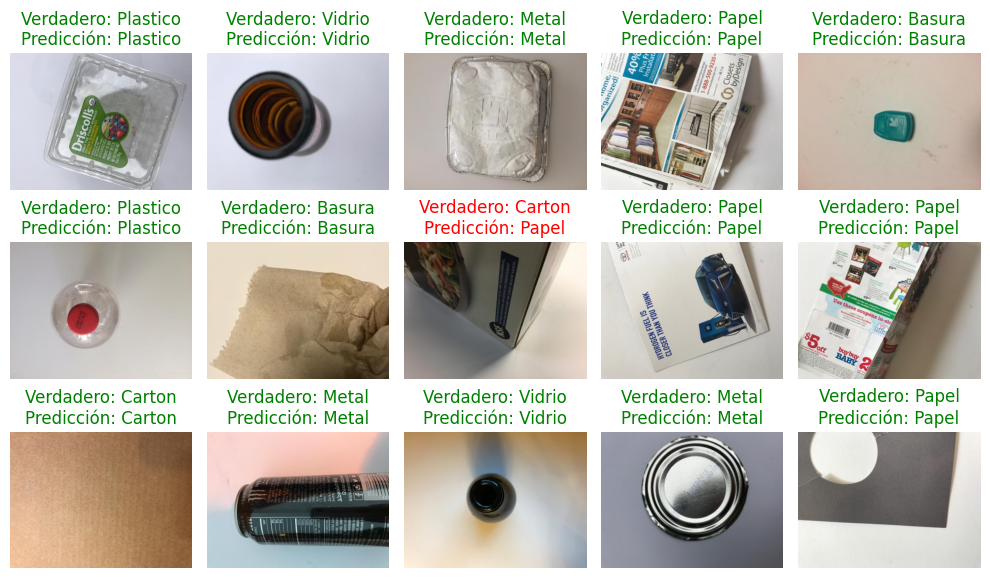

In [ ]:
import random
import matplotlib.pyplot as plt

def evaluate_image(model, image):
    model.eval()
    with torch.no_grad():
        output = model(image.unsqueeze(0))
        prediction = torch.argmax(output, dim=1).item()
    return prediction

r, c = 3, 5
fig = plt.figure(figsize=(2*c, 2*r))

for _r in range(r):
    for _c in range(c):
        plt.subplot(r, c, _r*c + _c + 1)
        ix = random.randint(0, len(dataset['test']) - 1)      # índice aleatorio
        img, true_label = dataset['test'][ix]                 # Obtener la imagen y la etiqueta verdadera
        prediction = evaluate_image(model_o, img.to(device))  # Realizar la predicción
        plt.imshow(img.permute(1, 2, 0).cpu().numpy())
        plt.axis("off")
        title_color = "green" if prediction == true_label else "red"
        plt.title(f"Verdadero: {classes[true_label]}\nPredicción: {classes[prediction]}", color=title_color)

plt.tight_layout()
plt.show()